# Modeling

This notebook uses a wide variety of modeling algorithms for a binary classification problem. It reads a file created from a feature selection process that has a reasonably small number of good variables, and we know their order of multivariate importance because we used a proper wrapper method. We can explore # input variables, model algorithms and tune model hyperparameters. At the end we can select our favorite algorithm, run it again and build the final model performace score percentile tables.

Here we call the larger fraction population the goods and the smaller fraction the bads. This notebook was originally
written for fraud detection but can be used for any binary classification. It uses detection rate as an appropriate measure of goodness.

Rather than use a built-in CV, we do a "manual CV" by running each model multiple (nitermax) times and average the performance on the training (trn), testing (tst) and out of time (oot) data sets.

In [1]:
from datetime import datetime
start_time = datetime.now()

import pandas as pd
import xgboost as xgb
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
import gc
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
%%time
vars = pd.read_csv('vars_final.csv')
print(vars.shape)
vars.head()

(96397, 22)
Wall time: 133 ms


,card_zip_total_14,card_zip3_max_30,Card_Merchnum_desc_total_0,card_zip3_max_60,card_merch_total_60,card_zip_max_60,Card_Merchnum_desc_max_60,card_zip_total_30,card_merch_avg_0,card_zip3_total_60,...,zip3_actual/max_60,Card_Merchnum_desc_max_30,amount_cat,card_zip3_avg_0,card_zip_avg_0,Merchnum_desc_med_0,Merchnum_desc_avg_0,Merchnum_desc_avg_1,Recnum,Fraud
0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,...,1.0,3.62,1,3.62,3.62,3.62,3.62,3.62,1,0
1,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,...,1.0,31.42,2,31.42,31.42,31.42,31.42,31.42,2,0
2,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,...,1.0,178.49,3,178.49,178.49,178.49,178.49,178.49,3,0
3,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,...,1.0,3.62,1,3.62,3.62,3.62,3.62,3.62,4,0
4,7.24,3.62,7.24,3.62,7.24,3.62,3.62,7.24,3.62,7.24,...,1.0,3.62,1,3.62,3.62,3.62,3.62,3.62,5,0


In [3]:
list(vars.columns)

['card_zip_total_14',
 'card_zip3_max_30',
 'Card_Merchnum_desc_total_0',
 'card_zip3_max_60',
 'card_merch_total_60',
 'card_zip_max_60',
 'Card_Merchnum_desc_max_60',
 'card_zip_total_30',
 'card_merch_avg_0',
 'card_zip3_total_60',
 'zip3_avg_0',
 'Card_Merchdesc_total_0',
 'zip3_actual/max_60',
 'Card_Merchnum_desc_max_30',
 'amount_cat',
 'card_zip3_avg_0',
 'card_zip_avg_0',
 'Merchnum_desc_med_0',
 'Merchnum_desc_avg_0',
 'Merchnum_desc_avg_1',
 'Recnum',
 'Fraud']

In [4]:
# set the number of variables desired here, and set the names of the y and record number properly
NVARS = 10

vars.rename(columns={'record':'Recnum'},inplace=True)
vars.rename(columns={'fraud_label':'Fraud'},inplace=True)
numvars = min(NVARS,len(vars)-2)
final_vars_list = ['Recnum','Fraud']
for i in range(numvars):
    final_vars_list.append(vars.columns[i])
    
final_vars_list

['Recnum',
 'Fraud',
 'card_zip_total_14',
 'card_zip3_max_30',
 'Card_Merchnum_desc_total_0',
 'card_zip3_max_60',
 'card_merch_total_60',
 'card_zip_max_60',
 'Card_Merchnum_desc_max_60',
 'card_zip_total_30',
 'card_merch_avg_0',
 'card_zip3_total_60']

In [5]:
vars = vars.filter(final_vars_list,axis=1)
vars.head()

,Recnum,Fraud,card_zip_total_14,card_zip3_max_30,Card_Merchnum_desc_total_0,card_zip3_max_60,card_merch_total_60,card_zip_max_60,Card_Merchnum_desc_max_60,card_zip_total_30,card_merch_avg_0,card_zip3_total_60
0,1,0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
1,2,0,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42
2,3,0,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49
3,4,0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
4,5,0,7.24,3.62,7.24,3.62,7.24,3.62,3.62,7.24,3.62,7.24


In [6]:
vars.shape

(96397, 12)

In [7]:
vars['Fraud'].sum()

1059

In [8]:
vars.head(10)

,Recnum,Fraud,card_zip_total_14,card_zip3_max_30,Card_Merchnum_desc_total_0,card_zip3_max_60,card_merch_total_60,card_zip_max_60,Card_Merchnum_desc_max_60,card_zip_total_30,card_merch_avg_0,card_zip3_total_60
0,1,0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
1,2,0,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42
2,3,0,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49
3,4,0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
4,5,0,7.24,3.62,7.24,3.62,7.24,3.62,3.62,7.24,3.62,7.24
5,6,0,3.67,3.67,3.67,3.67,3.67,3.67,3.67,3.67,3.67,3.67
6,7,0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
7,8,0,230.32,230.32,230.32,230.32,230.32,230.32,230.32,230.32,230.32,230.32
8,9,0,62.11,62.11,62.11,62.11,62.11,62.11,62.11,62.11,62.11,62.11
9,10,0,10.86,3.62,10.86,3.62,10.86,3.62,3.62,10.86,3.62,10.86


In [9]:
vars.shape

(96397, 12)

In [10]:
vars.describe()

,Recnum,Fraud,card_zip_total_14,card_zip3_max_30,Card_Merchnum_desc_total_0,card_zip3_max_60,card_merch_total_60,card_zip_max_60,Card_Merchnum_desc_max_60,card_zip_total_30,card_merch_avg_0,card_zip3_total_60
count,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.0000,96397.000000,96397.000000
mean,48365.481820,0.010986,806.656625,591.548408,524.640338,662.723920,1141.217228,583.064911,542.037643,992.1012,395.812357,1631.561943
std,27945.003883,0.104236,4186.923501,1136.743057,2617.102844,1196.229282,4551.733037,1121.768638,1090.108775,4346.6019,796.953627,5108.927755
min,1.000000,0.000000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.0100,0.010000,0.010000
25%,24154.000000,0.000000,85.000000,69.450000,43.400000,83.540000,108.810000,69.450000,50.450000,105.7500,34.990000,165.520000
50%,48365.000000,0.000000,257.000000,255.850000,155.000000,300.000000,348.790000,249.970000,216.970000,322.7800,141.000000,516.790000
75%,72578.000000,0.000000,718.640000,717.810000,492.000000,852.000000,1023.040000,705.020000,645.000000,906.2700,435.300000,1516.500000
max,96753.000000,1.000000,306633.410000,47900.000000,217467.180000,47900.000000,306633.410000,47900.000000,47900.000000,306633.4100,28392.840000,306633.410000


In [11]:
record_save = vars['Recnum']
Y_save = pd.DataFrame(vars.loc[:,'Fraud'])
Y_save.head()

,Fraud
0,0
1,0
2,0
3,0
4,0


## Scale and truncate field values

In [12]:
X_no_scaling = vars.drop(columns = ['Recnum','Fraud'])
X_no_scaling.describe()

,card_zip_total_14,card_zip3_max_30,Card_Merchnum_desc_total_0,card_zip3_max_60,card_merch_total_60,card_zip_max_60,Card_Merchnum_desc_max_60,card_zip_total_30,card_merch_avg_0,card_zip3_total_60
count,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.0000,96397.000000,96397.000000
mean,806.656625,591.548408,524.640338,662.723920,1141.217228,583.064911,542.037643,992.1012,395.812357,1631.561943
std,4186.923501,1136.743057,2617.102844,1196.229282,4551.733037,1121.768638,1090.108775,4346.6019,796.953627,5108.927755
min,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.0100,0.010000,0.010000
25%,85.000000,69.450000,43.400000,83.540000,108.810000,69.450000,50.450000,105.7500,34.990000,165.520000
50%,257.000000,255.850000,155.000000,300.000000,348.790000,249.970000,216.970000,322.7800,141.000000,516.790000
75%,718.640000,717.810000,492.000000,852.000000,1023.040000,705.020000,645.000000,906.2700,435.300000,1516.500000
max,306633.410000,47900.000000,217467.180000,47900.000000,306633.410000,47900.000000,47900.000000,306633.4100,28392.840000,306633.410000


In [13]:
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()

In [14]:
# use this to cap variables. For some problems it helps
Clip = 10

In [15]:
# push in any outlier values, then rescale
X.clip(-1*Clip,Clip,inplace=True)
# Now redo the zscaling after clipping
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()
X.describe()

,card_zip_total_14,card_zip3_max_30,Card_Merchnum_desc_total_0,card_zip3_max_60,card_merch_total_60,card_zip_max_60,Card_Merchnum_desc_max_60,card_zip_total_30,card_merch_avg_0,card_zip3_total_60
count,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04
mean,-1.385046e-15,6.821759e-15,-1.274005e-15,6.270961e-15,1.678860e-15,1.266896e-14,-1.410837e-15,-2.322741e-15,1.116460e-14,-2.196757e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.926586e-01,-5.203800e-01,-2.004623e-01,-5.540024e-01,-2.507193e-01,-5.197640e-01,-4.972234e-01,-2.282452e-01,-4.966442e-01,-3.193531e-01
25%,-1.723596e-01,-4.592932e-01,-1.838829e-01,-4.841747e-01,-2.268163e-01,-4.578617e-01,-4.509528e-01,-2.039182e-01,-4.527520e-01,-2.869569e-01
50%,-1.312794e-01,-2.953160e-01,-1.412403e-01,-3.032227e-01,-1.740935e-01,-2.969373e-01,-2.981974e-01,-1.539872e-01,-3.197330e-01,-2.182008e-01
75%,-2.102179e-02,1.110731e-01,-1.247194e-02,1.582273e-01,-2.596313e-02,1.087168e-01,9.445145e-02,-1.974674e-02,4.954823e-02,-2.252174e-02
max,7.304331e+01,4.161754e+01,8.289416e+01,3.948848e+01,6.711558e+01,4.218065e+01,4.344334e+01,7.031730e+01,3.513006e+01,5.969978e+01


In [16]:
# separate data into modeling (traintest) and out of time. Here I'm using the record number to do this separation.
# you need to change this oot record number to whatever is appropriate for your data
oot_recnum=83960
X_trntst = X[0:oot_recnum]
Y_trntst = Y_save[0:oot_recnum]
X_oot = X[oot_recnum:]
Y_oot = Y_save[oot_recnum:]

## Explore regularization

Solve a linear regression with ridge and lasso regularization and watch how the variable weights evolve with the regularization strength

In [17]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV 
from sklearn.metrics import mean_squared_error

In [18]:
alphas = 10**np.linspace(2,9,30)*0.5

In [19]:
X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

In [20]:
ridge = Ridge()
coefs = []
for a in alphas: 
    ridge.set_params(alpha=a) 
    ridge.fit(X_trn,Y_trn.values.ravel()) 
    coefs.append(ridge.coef_) 
np.shape(coefs)

(30, 10)

Wall time: 263 ms


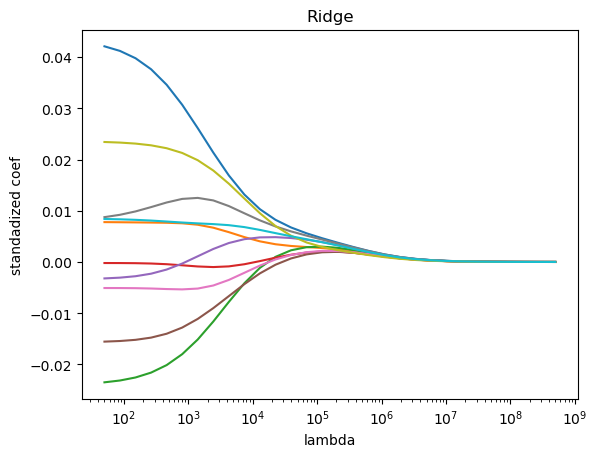

In [21]:
%%time
%matplotlib inline
ax = plt.gca() # Get the current Axes instance
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('lambda') 
plt.ylabel('standadized coef') 
plt.title('Ridge')
plt.savefig('ridge.png')

In [22]:
alphas = 10**np.linspace(-5,0,30)*0.5

In [23]:
%%time
# sometimes this cell takes a long time
lasso = Lasso(max_iter=10000) 
coefs = [] 
for a in alphas: 
    lasso.set_params(alpha=a) 
    lasso.fit(X_trn,Y_trn.values.ravel()) 
    coefs.append(lasso.coef_) 
# print('Shape:',np.shape(coefs)
print('Selected Features:', list(vars.columns[np.where(lasso.coef_!=0)[0]]))

Selected Features: []
Wall time: 4.24 s


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


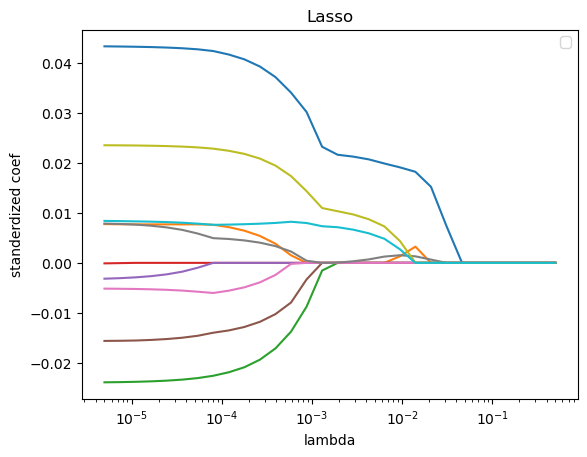

In [24]:
%matplotlib inline
ax = plt.gca() # Get the current Axes instance 
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('lambda')
plt.ylabel('standerdized coef') 
plt.title('Lasso')
plt.legend()
plt.savefig('lasso.png')

## Look at PCA

In [25]:
len(X_trntst.columns)

10

In [26]:
X_trntst_save = X_trntst.copy()

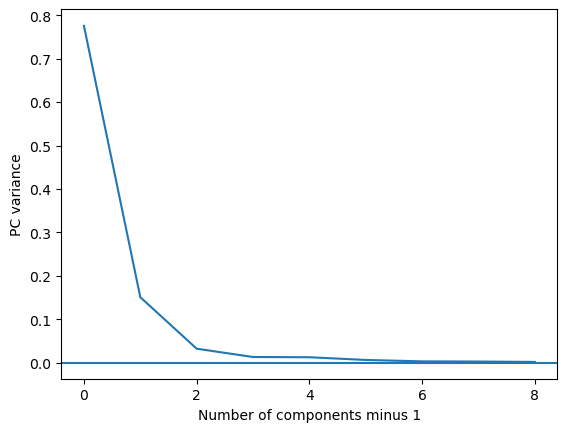

In [27]:
pca = PCA(n_components = .999, svd_solver = 'full')
pca.fit(X_trntst)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, len(X_trntst.columns), step=2))
plt.axhline(y=0,xmin=0,xmax=len(X_trntst.columns))
X_trntst = X_trntst_save.copy()

In [28]:
# We look at the above picture, select how many PCs we want to keep, and then redo the PCA with just this many PCs
pca = PCA(n_components = 6, svd_solver = 'full')
princ_comps = pca.fit_transform(X_trntst)
X_trntst_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
X_trntst_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,-1.174399,0.494334,-0.092018,-0.021808,0.033107,-0.008285
1,-1.123320,0.459608,-0.099860,-0.019608,0.031611,-0.008813
2,-0.853093,0.275898,-0.141349,-0.007964,0.023699,-0.011605
3,-1.174399,0.494334,-0.092018,-0.021808,0.033107,-0.008285
4,-1.172895,0.495673,-0.092492,-0.021469,0.033263,-0.008042


In [29]:
princ_comps = pca.transform(X_oot)
X_oot_orig_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)],index=X_oot.index)
X_oot_orig_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
83960,-1.118873,0.456585,-0.100543,-0.019416,0.031481,-0.008859
83961,-1.167234,0.489463,-0.093118,-0.021500,0.032897,-0.008359
83962,-0.590243,0.208423,-0.155514,-0.000613,-0.018445,-0.038149
83963,-1.019700,0.405785,0.013495,-0.028259,0.085827,0.009029
83964,2.555720,-0.991586,-0.166651,-0.133502,-0.175911,-0.307594


In [30]:
X_trntst.describe()

,card_zip_total_14,card_zip3_max_30,Card_Merchnum_desc_total_0,card_zip3_max_60,card_merch_total_60,card_zip_max_60,Card_Merchnum_desc_max_60,card_zip_total_30,card_merch_avg_0,card_zip3_total_60
count,83960.000000,83960.000000,83960.000000,83960.000000,83960.000000,83960.000000,83960.000000,83960.000000,83960.000000,83960.000000
mean,0.002397,0.003232,0.002560,0.000926,0.002714,0.001611,0.002925,0.002889,0.003243,0.001673
std,1.057628,1.011516,1.058751,1.010249,1.045994,1.012790,1.016311,1.052711,1.000509,1.037970
min,-0.192659,-0.520380,-0.200462,-0.554002,-0.250719,-0.519764,-0.497223,-0.228245,-0.496644,-0.319353
25%,-0.172360,-0.461809,-0.184441,-0.486578,-0.226526,-0.460046,-0.452320,-0.203717,-0.455287,-0.286530
50%,-0.131041,-0.297520,-0.142196,-0.304059,-0.173439,-0.298858,-0.300005,-0.153388,-0.320367,-0.217284
75%,-0.021056,0.117398,-0.013257,0.164213,-0.023995,0.111266,0.096600,-0.018375,0.052531,-0.022944
max,73.043311,41.617542,82.894159,39.488480,67.115578,42.180654,43.443337,70.317300,35.130059,59.699777


In [31]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6
count,12437.000000,12437.000000,12437.000000,12437.000000,12437.000000,12437.000000
mean,-0.058725,0.003192,0.012738,-0.001039,0.004948,0.008255
std,1.968747,1.045022,0.596902,0.358075,0.380468,0.265990
min,-1.181032,-33.500144,-10.305328,-10.633832,-5.767930,-7.237008
25%,-1.003227,-0.143125,-0.167878,-0.022734,-0.008807,-0.024255
50%,-0.639736,0.242783,-0.101964,-0.010283,0.024425,-0.010988
75%,0.204813,0.421410,0.015908,0.034186,0.038142,-0.000499
max,54.828427,5.339886,15.837616,10.218952,11.503219,5.716424


In [32]:
# zscale the PCs
mean = X_trntst_pca.mean()
stdev = X_trntst_pca.std()
X_trntst_pca = (X_trntst_pca - mean)/stdev
X_oot_orig_pca = (X_oot_orig_pca - mean)/stdev

In [33]:
X_trntst_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6
count,8.396000e+04,8.396000e+04,8.396000e+04,8.396000e+04,8.396000e+04,8.396000e+04
mean,-7.851311e-16,3.417493e-16,3.462055e-16,-8.228556e-17,-6.001961e-17,-2.840682e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.115122e-01,-3.535695e+01,-2.367132e+01,-3.128579e+01,-2.283611e+01,-3.447908e+01
25%,-3.520775e-01,-1.244159e-01,-2.885576e-01,-6.041834e-02,-5.586820e-02,-1.044357e-01
50%,-2.368678e-01,2.007283e-01,-1.683626e-01,-2.947489e-02,5.771821e-02,-4.400689e-02
75%,6.864125e-02,3.477347e-01,2.133053e-02,8.161838e-02,8.929368e-02,-1.394494e-02
max,5.281714e+01,5.447275e+01,3.143314e+01,3.501822e+01,3.615515e+01,3.705315e+01


In [34]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6
count,12437.000000,12437.000000,12437.000000,12437.000000,12437.000000,12437.000000
mean,-0.020462,0.002521,0.021717,-0.002768,0.013463,0.031483
std,0.685979,0.825330,1.017667,0.953855,1.035295,1.014419
min,-0.411512,-26.457504,-17.569703,-28.326819,-15.695181,-27.600089
25%,-0.349559,-0.113036,-0.286218,-0.060560,-0.023966,-0.092502
50%,-0.222906,0.191743,-0.173841,-0.027393,0.066462,-0.041904
75%,0.071364,0.332818,0.027121,0.091066,0.103789,-0.001903
max,19.104103,4.217297,27.001781,27.221646,31.301540,21.800972


In [35]:
X_trntst_pca.shape

(83960, 6)

In [36]:
X_oot_orig_pca.shape

(12437, 6)

## Subsample the larger class if desired

In [37]:
# set the ratio of goods to bads that you would like. This next line is the ratio of goods to bads that you want for modeling
sample_ratio_desired = 1

temp = X_trntst.copy()
temp['Fraud'] = Y_trntst['Fraud']
temp.head()
goods = temp[temp['Fraud']==0]
bads = temp[temp['Fraud']==1]
actual_bad_fraction = len(bads)/len(temp)
actual_good_fraction = 1 - actual_bad_fraction
print(actual_bad_fraction)
fraction = sample_ratio_desired * actual_bad_fraction
goods_sampled = goods.sample(frac = fraction)
all_sampled = pd.concat([goods_sampled,bads])
all_sampled.sort_index(inplace=True)
Y_trntst_sampled = pd.DataFrame(all_sampled['Fraud'])
X_trntst_sampled = all_sampled.drop(columns=['Fraud'])
del [temp,goods,bads,all_sampled]
gc.collect()
print(X_trntst_sampled.shape,len(Y_trntst_sampled))

0.010481181515007145
(1751, 10) 1751


In [38]:
niter = 0
nitermax = 5
X_oot_orig = X_oot.copy()
pd.options.mode.chained_assignment = None  # default='warn'

## Models

You can comment in/out any of these model cells and just explore one model type. You can also just rerun that single cell multiple times (hit shift-enter on that cell) as you manually explore different model hyperparameters.

In [39]:
Modeling_output = pd.DataFrame(columns=['Model','Trn','Tst','OOT'],index=range(1000))
counter = 0
model_counter = 0

In [40]:
%%time
# Logistic regression

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = LogisticRegression(max_iter=20)
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['log reg',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.6393700787401575 0.5877551020408164 0.39106145251396646


C:\Users\micha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\micha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

1 0.6231647634584013 0.6404494382022472 0.46368715083798884
2 0.6215753424657534 0.6317567567567568 0.3743016759776536
3 0.6402640264026402 0.6058394160583942 0.35195530726256985
4 0.62 0.6357142857142857 0.4134078212290503
trn    0.628875
tst    0.620303
oot    0.398883
dtype: float64
Wall time: 299 ms


C:\Users\micha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [41]:
%%time
# Single DT

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = DecisionTreeClassifier(max_depth=8,min_samples_split=40,min_samples_leaf=30)
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['DT',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1

print(FDR3.mean())
model_counter = model_counter + 1

0 0.7142857142857143 0.7090301003344481 0.5251396648044693
1 0.7382875605815832 0.6934865900383141 0.45251396648044695
2 0.7572347266881029 0.689922480620155 0.5139664804469274
3 0.7476489028213166 0.6859504132231405 0.5195530726256983
4 0.7032786885245902 0.6703703703703704 0.3575418994413408
trn    0.732147
tst    0.689752
oot    0.473743
dtype: float64
Wall time: 1.45 s


In [42]:
%%time
# RF

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = RandomForestClassifier(n_estimators=8,max_depth=8,min_samples_split=40,min_samples_leaf=30,max_features=5)
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['RF',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.7713815789473685 0.7536764705882353 0.5251396648044693
1 0.8091353996737357 0.7677902621722846 0.553072625698324
2 0.7830188679245284 0.7336065573770492 0.553072625698324
3 0.7830342577487766 0.7490636704119851 0.5642458100558659
4 0.7591125198098256 0.7550200803212851 0.553072625698324
trn    0.781137
tst    0.751831
oot    0.549721
dtype: float64
Wall time: 3.71 s


In [43]:
%%time
# LGBM

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = lgb.LGBMClassifier(num_leaves=8,n_estimators=10)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.7799043062200957 0.7430830039525692 0.4134078212290503
1 0.778534923339012 0.7235494880546075 0.48044692737430167
2 0.7652027027027027 0.7986111111111112 0.547486033519553
3 0.7736757624398074 0.7159533073929961 0.5586592178770949
4 0.7805280528052805 0.7700729927007299 0.26256983240223464
trn    0.775569
tst    0.750254
oot    0.452514
dtype: float64
Wall time: 357 ms


In [44]:
%%time
# NN

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = MLPClassifier(hidden_layer_sizes=(20,20,20),activation ='logistic',alpha = 0.001, learning_rate ='constant',solver = 'adam')

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['NN',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.6968253968253968 0.728 0.547486033519553
1 0.7126805778491172 0.6848249027237354 0.5418994413407822
2 0.7107843137254902 0.667910447761194 0.5251396648044693
3 0.7095238095238096 0.712 0.48044692737430167
4 0.7019543973941368 0.7105263157894737 0.5139664804469274
trn    0.706354
tst    0.700652
oot    0.521788
dtype: float64
Wall time: 1min 8s


In [45]:
# %%time
# # NN on pc's

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     model = MLPClassifier(hidden_layer_sizes=(2))

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['NN_PCs',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [46]:
# %%time
# # GBC

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = GradientBoostingClassifier(max_depth=4,n_estimators=10)

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['GBC',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [47]:
%%time
# Catboost

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = CatBoostClassifier(verbose=0, max_depth=6, iterations=15)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['cat boost',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.7541254125412541 0.718978102189781 0.5698324022346368
1 0.7462437395659433 0.7437722419928826 0.5363128491620112
2 0.7244897959183674 0.7534246575342466 0.547486033519553
3 0.757328990228013 0.7142857142857143 0.547486033519553
4 0.7527386541471048 0.7344398340248963 0.5139664804469274
trn    0.746985
tst    0.732980
oot    0.543017
dtype: float64
Wall time: 699 ms


In [48]:
# %%time
# # NOTE this cell has been substantially modified to evaluate a sampled trn/tst data set. 
# # Only use this cell if you do downsampling of the goods.
# # each good needs to have a weight of (1-actual_ratio)/sample_ratio_desired
# # it's hard to get the correct FDR@3% for the actual train and test, so I just use the original trntst after the model is built for evaluation

# xmult = actual_good_fraction / (actual_bad_fraction * sample_ratio_desired)
# print(xmult)
# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_sampled, Y_trntst_sampled, test_size = .3)

#     model = CatBoostClassifier(verbose=0, max_depth=2, iterations=5)

#     model.fit(X_trn, Y_trn.values.ravel())  
    
#     X_oot = X_oot_orig.copy()
#     X_trn = X_trntst.copy()
#     Y_trn = Y_trntst.copy()
#     X_tst = X_trntst.copy()
#     Y_tst = Y_trntst.copy()


#     predictions = model.predict_proba(X_trntst)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trntst['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_trntst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_trntst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['cat boost_sampled',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [49]:
# %%time
# # Catboost on pc's

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     model = CatBoostClassifier(verbose=0, max_depth=2, iterations=5)


#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['cat boost_PCs',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [50]:
# %%time
# # unsupervised model using pc's. 

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     pow = 2
#     oop = 1/pow
#     predictions = ((X_trn.abs()**pow).sum(axis=1))**oop
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = ((X_tst.abs()**pow).sum(axis=1))**oop
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = ((X_oot.abs()**pow).sum(axis=1))**oop
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['unsupervised outliers',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [51]:
# %%time
# # XGB

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = xgb.XGBClassifier(max_depth=2, n_estimators=5)

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['XGB',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [52]:
# %%time
# # Knn
# # Knn can be very slow with a lot of records.

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = KNeighborsClassifier(n_neighbors=50) 
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['Knn',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [53]:
# %%time
# # SVM
# # SVM can be very slow. It scales like the # training records cubed

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = svm.SVC(
#         C=.1, 
# #         gamma=100,
# #         kernel='linear',
#         kernel='poly',
#         probability=True)
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['SVM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

## Model comparison plots

In [54]:
df = Modeling_output.dropna()
df.head(20)

,Model,Trn,Tst,OOT
0,log reg,0.63937,0.587755,0.391061
1,log reg,0.623165,0.640449,0.463687
2,log reg,0.621575,0.631757,0.374302
3,log reg,0.640264,0.605839,0.351955
4,log reg,0.62,0.635714,0.413408
5,DT,0.714286,0.70903,0.52514
6,DT,0.738288,0.693487,0.452514
7,DT,0.757235,0.689922,0.513966
8,DT,0.747649,0.68595,0.519553
9,DT,0.703279,0.67037,0.357542


In [55]:
df.shape

(30, 4)

In [56]:
df_unpivot = df.melt( id_vars='Model', value_vars=['Trn','Tst','OOT'], var_name=['Type'], value_name='Value')
df_unpivot.head()

,Model,Type,Value
0,log reg,Trn,0.63937
1,log reg,Trn,0.623165
2,log reg,Trn,0.621575
3,log reg,Trn,0.640264
4,log reg,Trn,0.62


In [57]:
df_compare = df_unpivot[(df_unpivot['Type']=='Trn') | (df_unpivot['Type']=='Tst') | (df_unpivot['Type']=='OOT')]
df_compare.head()

,Model,Type,Value
0,log reg,Trn,0.63937
1,log reg,Trn,0.623165
2,log reg,Trn,0.621575
3,log reg,Trn,0.640264
4,log reg,Trn,0.62


In [58]:
output = df.groupby('Model').agg({'Trn':['mean','std'],'Tst':['mean','std'],'OOT':['mean','std']})
output

Trn                 Tst                 OOT          
               mean       std      mean       std      mean       std
Model                                                                
DT         0.732147  0.022693  0.689752  0.013926  0.473743  0.071259
LGBM       0.775569  0.006388  0.750254  0.034177  0.452514  0.121114
NN         0.706354  0.006705  0.700652  0.023962  0.521788  0.026676
RF         0.781137  0.018516  0.751831  0.012329  0.549721  0.014568
cat boost  0.746985  0.013207  0.732980  0.016448  0.543017  0.020297
log reg    0.628875  0.010056  0.620303  0.022601  0.398883  0.042656

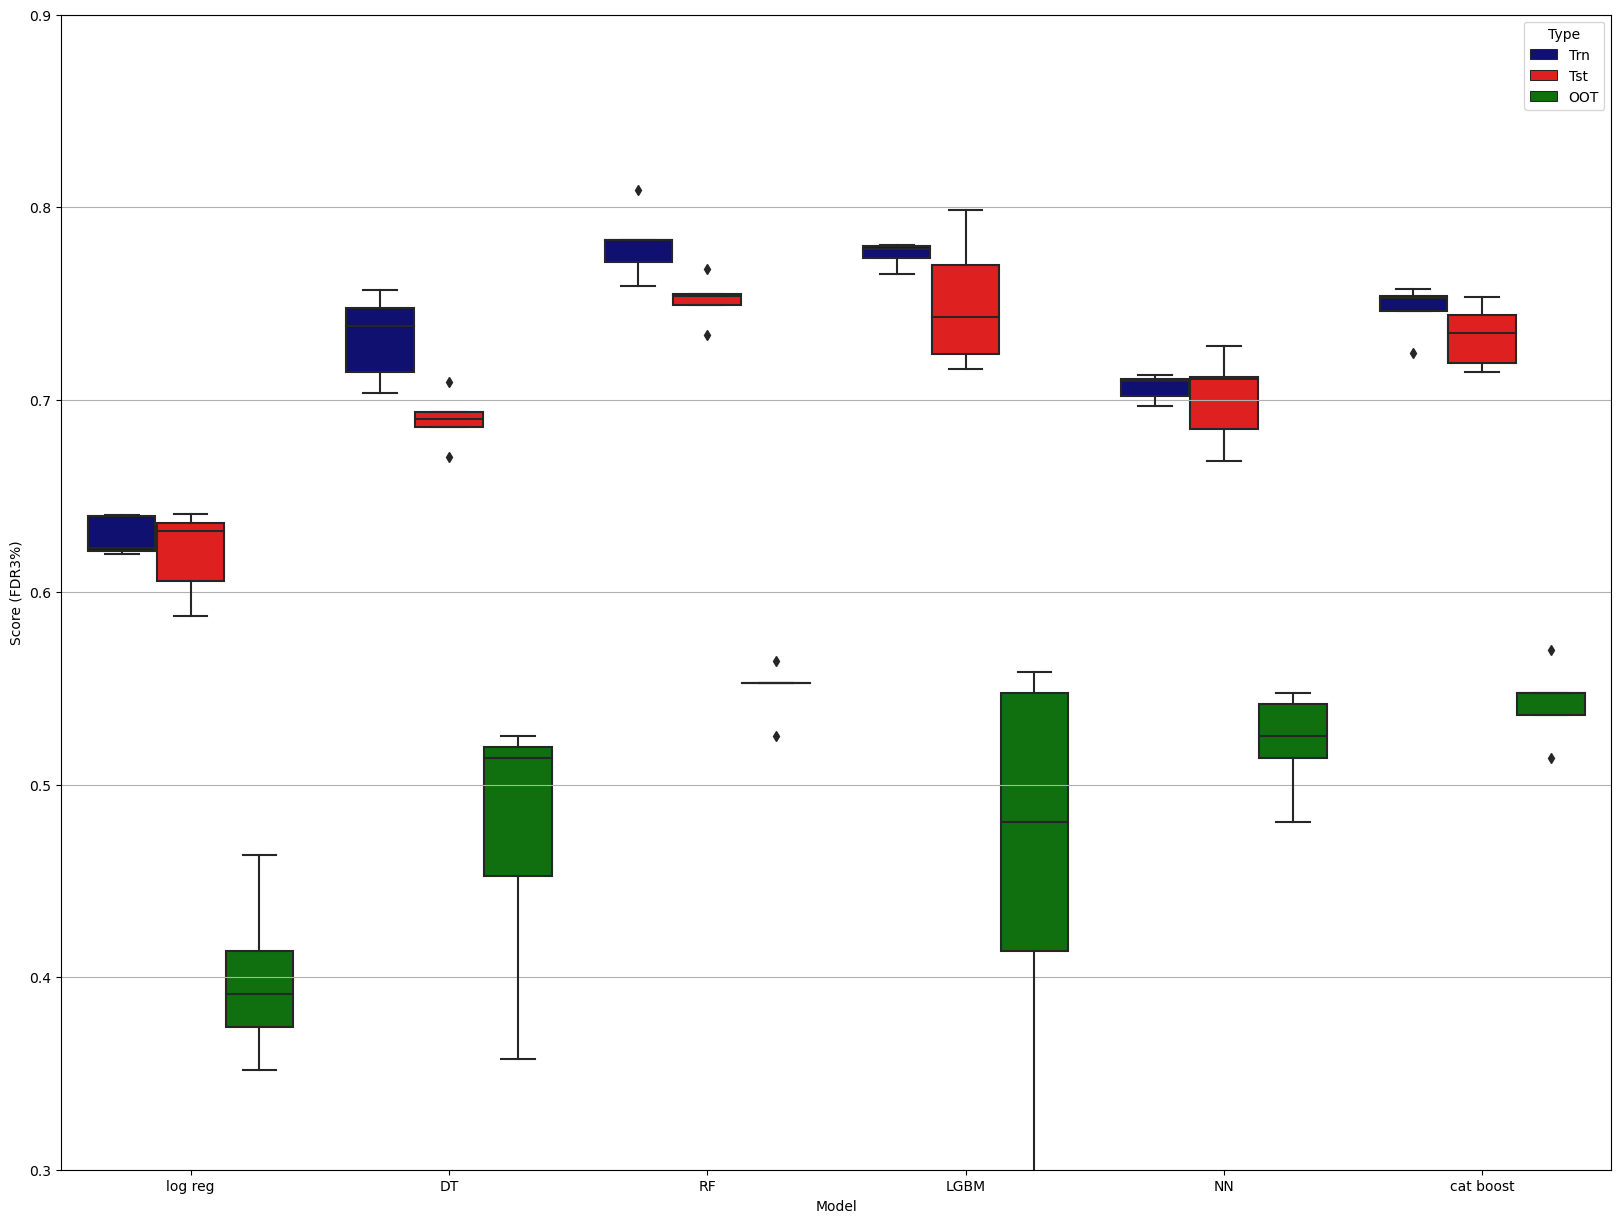

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
ax = sns.boxplot(x='Model',y='Value',hue='Type', data=df_compare, palette=['navy','r','g'])

plt.ylim(.3,.9)
plt.ylabel('Score (FDR3%)')
plt.grid(axis='y')
plt.savefig('modeling.png')
plt.show()

0 0.7200647249190939 0.6603053435114504 0.547486033519553
1 0.6537842190016103 0.6563706563706564 0.4860335195530726
2 0.6973684210526315 0.6948529411764706 0.5363128491620112
3 0.6716917922948074 0.6925795053003534 0.5251396648044693
4 0.685214626391097 0.6812749003984063 0.5083798882681564
loop trn tst oot 1 0.6856247567318481 0.6770766693514674 0.5206703910614525
0 0.8233387358184765 0.7718631178707225 0.5642458100558659
1 0.8267326732673267 0.7992700729927007 0.5418994413407822
2 0.8295081967213115 0.7962962962962963 0.553072625698324
3 0.8341463414634146 0.7962264150943397 0.547486033519553
4 0.8241206030150754 0.7597173144876325 0.553072625698324
loop trn tst oot 2 0.8275693100571209 0.7846746433483383 0.5519553072625698
0 0.9354838709677419 0.8178694158075601 0.5698324022346368
1 0.9321766561514195 0.7479674796747967 0.5642458100558659
2 0.9487179487179487 0.7890625 0.5698324022346368
3 0.9281045751633987 0.7761194029850746 0.49162011173184356
4 0.9360655737704918 0.792592592592

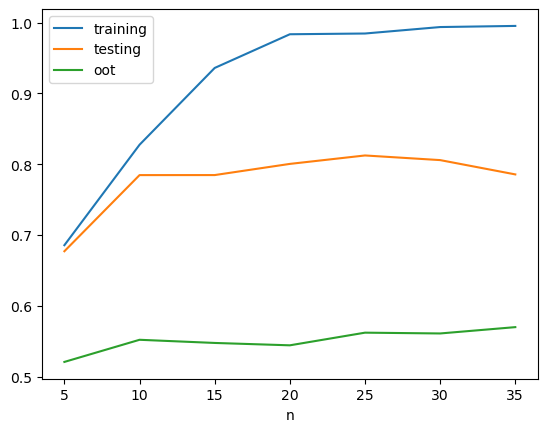

In [60]:
training = []
testing = []
oot = []
results = pd.DataFrame(np.zeros((niter,3)),columns=['trn','tst','oot'])
for i in range(1,8,1):
    for niter in range(nitermax):
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
        
        model = RandomForestClassifier(n_estimators=i*5,max_depth=i*5,min_samples_split=10,min_samples_leaf=10,max_features=10)
        
        model.fit(X_trn, Y_trn.values.ravel()) 

        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()
    
        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*0.03))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*0.03))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*0.03))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, results.loc[niter,'trn'],results.loc[niter,'tst'],results.loc[niter,'oot'],)

    results_mean_trn = results['trn'].mean()
    results_mean_tst = results['tst'].mean()
    results_mean_oot = results['oot'].mean()
    print('loop', 'trn', 'tst', 'oot', i, results_mean_trn, results_mean_tst, results_mean_oot)
    training.append(results_mean_trn)
    testing.append(results_mean_tst)
    oot.append(results_mean_oot)

table=pd.DataFrame({'n': range(5,5*(len(training)+1),5),'training':training,'testing':testing,'oot':oot})
table.set_index('n',inplace=True) 
table.plot()
plt.savefig('complexity_rf.pdf', format='pdf')
plt.show()


0 0.6379310344827587 0.6198347107438017 0.3854748603351955
1 0.6343402225755167 0.649402390438247 0.4692737430167598
2 0.6513911620294599 0.587360594795539 0.46368715083798884
3 0.642504118616145 0.6703296703296703 0.43575418994413406
4 0.5931372549019608 0.6268656716417911 0.3743016759776536
loop trn tst oot 1 0.6318607585211683 0.6307586075898098 0.4256983240223464
0 0.7714285714285715 0.7578947368421053 0.553072625698324
1 0.7488 0.7176470588235294 0.5754189944134078
2 0.7520259319286872 0.6806083650190115 0.553072625698324
3 0.7608695652173914 0.7340425531914894 0.5586592178770949
4 0.7584541062801933 0.7606177606177607 0.553072625698324
loop trn tst oot 2 0.7583156349709685 0.7301620948987793 0.5586592178770949
0 0.8294314381270903 0.7411347517730497 0.553072625698324
1 0.782608695652174 0.7344262295081967 0.5418994413407822
2 0.7898089171974523 0.7857142857142857 0.547486033519553
3 0.8092105263157895 0.7352941176470589 0.5698324022346368
4 0.7909238249594813 0.7452471482889734 0

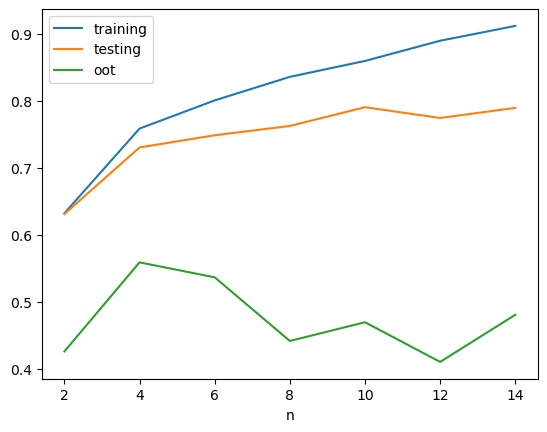

In [61]:
training = []
testing = []
oot = []
results = pd.DataFrame(np.zeros((niter,3)),columns=['trn','tst','oot'])
for i in range(1,8,1):
    for niter in range(nitermax):
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
        
        model = lgb.LGBMClassifier(num_leaves=i*2,n_estimators= i*10)
        
        model.fit(X_trn, Y_trn.values.ravel()) 

        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()
    
        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*0.03))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*0.03))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*0.03))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, results.loc[niter,'trn'],results.loc[niter,'tst'],results.loc[niter,'oot'],)

    results_mean_trn = results['trn'].mean()
    results_mean_tst = results['tst'].mean()
    results_mean_oot = results['oot'].mean()
    print('loop', 'trn', 'tst', 'oot', i, results_mean_trn, results_mean_tst, results_mean_oot)
    training.append(results_mean_trn)
    testing.append(results_mean_tst)
    oot.append(results_mean_oot)

table=pd.DataFrame({'n': range(2,16,2),'training':training,'testing':testing,'oot':oot})
table.set_index('n',inplace=True) 
table.plot()
plt.savefig('complexity_lgbm.pdf', format='pdf')
plt.show()


0 0.6759868421052632 0.6323529411764706 0.4860335195530726
1 0.6534653465346535 0.6021897810218978 0.3854748603351955
2 0.6661045531197302 0.6655052264808362 0.4692737430167598
3 0.6566666666666666 0.5928571428571429 0.4301675977653631
4 0.665079365079365 0.656 0.44692737430167595
loop trn tst oot 1 0.6634605547011356 0.6297810183072696 0.44357541899441344
0 0.780448717948718 0.72265625 0.5195530726256983
1 0.7957860615883307 0.7262357414448669 0.5363128491620112
2 0.7831932773109244 0.7052631578947368 0.5418994413407822
3 0.819047619047619 0.748 0.4245810055865922
4 0.8087248322147651 0.7429577464788732 0.5418994413407822
loop trn tst oot 2 0.7974401016220714 0.7290225791636953 0.5128491620111733
0 0.8741935483870967 0.7615384615384615 0.5418994413407822
1 0.8745928338762216 0.6842105263157895 0.48044692737430167
2 0.8975206611570248 0.730909090909091 0.3128491620111732
3 0.9109697933227345 0.7529880478087649 0.5418994413407822
4 0.8624787775891342 0.7216494845360825 0.368715083798882

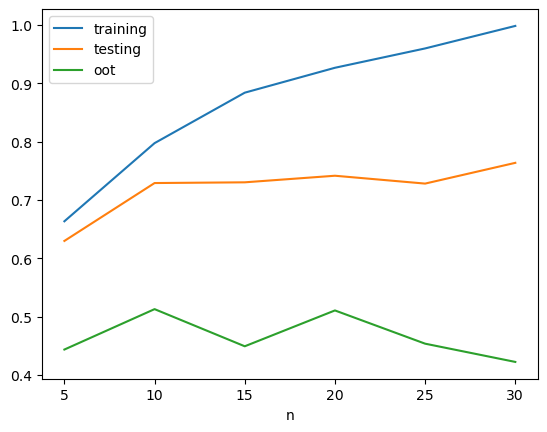

In [62]:
training = []
testing = []
oot = []
results = pd.DataFrame(np.zeros((niter,3)),columns=['trn','tst','oot'])
for i in range(1,7,1):
    for niter in range(nitermax):
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
        
        model = DecisionTreeClassifier(max_depth=i*5,min_samples_split=(55 - i*5),min_samples_leaf=(35 - i*5))
        
        model.fit(X_trn, Y_trn.values.ravel()) 

        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()
    
        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*0.03))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*0.03))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*0.03))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, results.loc[niter,'trn'],results.loc[niter,'tst'],results.loc[niter,'oot'],)

    results_mean_trn = results['trn'].mean()
    results_mean_tst = results['tst'].mean()
    results_mean_oot = results['oot'].mean()
    print('loop', 'trn', 'tst', 'oot', i, results_mean_trn, results_mean_tst, results_mean_oot)
    training.append(results_mean_trn)
    testing.append(results_mean_tst)
    oot.append(results_mean_oot)

table=pd.DataFrame({'n': range(5, 5*(len(training)+1),5),'training':training,'testing':testing,'oot':oot})
table.set_index('n',inplace=True) 
table.plot()
plt.savefig('complexity_DT.pdf', format='pdf')
plt.show()


0 0.624390243902439 0.6716981132075471 0.39664804469273746
1 0.22820919175911253 0.23694779116465864 0.0893854748603352
2 0.03896103896103896 0.026515151515151516 0.055865921787709494
3 0.020537124802527645 0.008097165991902834 0.055865921787709494
4 0.27375201288244766 0.22007722007722008 0.09497206703910614
loop trn tst oot 1 0.2371699224615132 0.23266708839129602 0.13854748603351955
0 0.7084690553745928 0.7406015037593985 0.5418994413407822
1 0.7231270358306189 0.7105263157894737 0.5418994413407822
2 0.719551282051282 0.6796875 0.5139664804469274
3 0.7017543859649122 0.7154150197628458 0.4860335195530726
4 0.7126436781609196 0.7232472324723247 0.5921787709497207
loop trn tst oot 11 0.7131090874764651 0.7138955143568084 0.5351955307262569
0 0.7444794952681388 0.7317073170731707 0.43575418994413406
1 0.7641357027463651 0.7662835249042146 0.5754189944134078
2 0.7380952380952381 0.78 0.5810055865921788
3 0.7537190082644628 0.7345454545454545 0.553072625698324
4 0.7317460317460317 0.732 

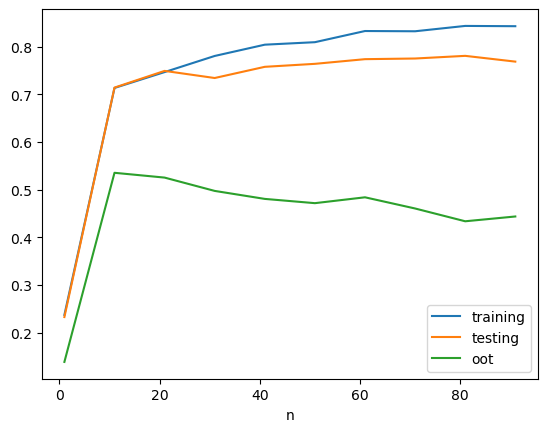

In [63]:
training = []
testing = []
oot = []
results = pd.DataFrame(np.zeros((niter,3)),columns=['trn','tst','oot'])
for i in range(1,100,10):
    for niter in range(nitermax):
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
        
        model = MLPClassifier(hidden_layer_sizes=(i,i),alpha = (.000001),learning_rate_init = 0.001)

        
        model.fit(X_trn, Y_trn.values.ravel()) 

        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()
    
        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*0.03))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*0.03))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*0.03))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, results.loc[niter,'trn'],results.loc[niter,'tst'],results.loc[niter,'oot'],)

    results_mean_trn = results['trn'].mean()
    results_mean_tst = results['tst'].mean()
    results_mean_oot = results['oot'].mean()
    print('loop', 'trn', 'tst', 'oot', i, results_mean_trn, results_mean_tst, results_mean_oot)
    training.append(results_mean_trn)
    testing.append(results_mean_tst)
    oot.append(results_mean_oot)

table=pd.DataFrame({'n': range(1,100,10),'training':training,'testing':testing,'oot':oot})
table.set_index('n',inplace=True) 
table.plot()
plt.savefig('complexity_NN.pdf', format='pdf')
plt.show()


In [64]:
print('duration: ', datetime.now() - start_time)

duration:  0:20:28.111152


The rest of the notebook makes the tables for your final model of choice. You need to run that final model only once (no CV). If you want you can run the below cell over and over by itself until it gives you a model you like (due to the stochastic nature of some ML algorithms, but you can't change from your best hyperparameters.

In [75]:
%%time

for niter in range(30):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

# here's where you put your final model of choice

    model = CatBoostClassifier(verbose=0, max_depth=6, iterations=15)
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['RF',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    if(FDR3.loc[niter, 'oot'] > .56): break
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.7649918962722853 0.779467680608365 0.5698324022346368
trn    0.749159
tst    0.745078
oot    0.543017
dtype: float64
Wall time: 107 ms


In [76]:
X_trn_eval = X_trn.copy()
X_tst_eval = X_tst.copy()
X_oot_eval = X_oot.copy()

In [77]:
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','%cg','FDR','KS','FPR']
FDR_trn = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_tst = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_oot = pd.DataFrame(np.zeros((101, 13)), columns = cols)
trn_sorted = X_trn_eval.sort_values('predicted',ascending=False)
tst_sorted = X_tst_eval.sort_values('predicted',ascending=False)
oot_sorted = X_oot_eval.sort_values('predicted',ascending=False)
bad_tot_trn = sum(X_trn_eval.loc[:, 'Fraud'])
bad_tot_tst = sum(X_tst_eval.loc[:, 'Fraud'])
bad_tot_oot = sum(X_oot_eval.loc[:, 'Fraud'])
num_tot_trn = len(X_trn_eval)
num_tot_tst = len(X_tst_eval)
num_tot_oot = len(X_oot_eval)
good_tot_trn = num_tot_trn - bad_tot_trn
good_tot_tst = num_tot_tst - bad_tot_tst
good_tot_oot = num_tot_oot - bad_tot_oot
oot_sorted.head(20)

,card_zip_total_14,card_zip3_max_30,Card_Merchnum_desc_total_0,card_zip3_max_60,card_merch_total_60,card_zip_max_60,Card_Merchnum_desc_max_60,card_zip_total_30,card_merch_avg_0,card_zip3_total_60,predicted,Fraud
89074,4.975602,2.664042,6.955103,2.472065,4.503318,2.707167,2.823427,4.750152,1.313496,3.916195,0.951689,1
89077,5.217299,2.664042,7.156860,2.472065,4.725645,2.707167,2.823427,4.982970,1.175231,4.114274,0.951689,1
89121,6.879966,2.664042,1.743221,2.472065,6.255053,2.707167,2.823427,6.584557,0.595229,5.476881,0.932141,1
89128,6.991946,2.664042,1.922370,2.472065,6.358058,2.707167,2.823427,6.692423,0.539276,5.568651,0.932141,1
89117,6.403438,2.664042,0.980855,2.472065,5.816717,2.707167,2.823427,6.125534,0.541938,5.086351,0.930789,1
89120,6.488149,2.664042,1.116379,2.472065,5.894639,2.707167,2.823427,6.207134,0.457145,5.155774,0.930789,1
89114,6.304671,2.664042,0.822845,2.472065,5.725866,2.707167,2.823427,6.030396,0.645879,5.005408,0.930789,1
89060,3.513418,2.664042,4.615856,2.472065,3.158325,2.707167,2.823427,3.341684,1.001073,2.717891,0.888343,1
89068,4.266778,2.664042,5.821105,2.472065,3.851305,2.707167,2.823427,4.067368,1.176799,3.335292,0.888343,1
89129,7.081771,2.664042,-0.056761,2.472065,6.440684,2.707167,-0.053286,6.778948,0.482873,5.642266,0.886368,1


In [78]:
for i in range(101):
    percent_rows_trn = int(round(X_trn_eval.shape[0]*0.01*i))
    percent_rows_tst = int(round(X_tst_eval.shape[0]*0.01*i))
    percent_rows_oot = int(round(X_oot_eval.shape[0]*0.01*i))
    temp_trn = trn_sorted.head(percent_rows_trn)
    temp_tst = tst_sorted.head(percent_rows_tst)
    temp_oot = oot_sorted.head(percent_rows_oot)
    num_bad_trn = sum(temp_trn.loc[:,'Fraud'])
    num_bad_tst = sum(temp_tst.loc[:,'Fraud'])
    num_bad_oot = sum(temp_oot.loc[:,'Fraud'])
    num_tot_trn = len(temp_trn)
    num_tot_tst = len(temp_tst)
    num_tot_oot = len(temp_oot)
    num_good_trn = num_tot_trn - num_bad_trn
    num_good_tst = num_tot_tst - num_bad_tst
    num_good_oot = num_tot_oot - num_bad_oot
    
    FDR_trn.loc[i, 'bin'] = i
    FDR_trn.loc[i,'#recs'] = 0
    FDR_trn.loc[i, 'tot'] = num_tot_trn
    FDR_trn.loc[i, 'cg'] = num_good_trn
    FDR_trn.loc[i, 'cb'] = num_bad_trn
    FDR_tst.loc[i, 'bin'] = i
    FDR_tst.loc[i, 'tot'] = num_tot_tst
    FDR_tst.loc[i, 'cg'] = num_good_tst
    FDR_tst.loc[i, 'cb'] = num_bad_tst
    FDR_oot.loc[i, 'bin'] = i
    FDR_oot.loc[i, 'tot'] = num_tot_oot
    FDR_oot.loc[i, 'cg'] = num_good_oot
    FDR_oot.loc[i, 'cb'] = num_bad_oot
    if i != 0:
        FDR_trn.loc[i, '#g'] = num_good_trn - FDR_trn.loc[i-1, 'cg']
        FDR_trn.loc[i, '#b'] = num_bad_trn - FDR_trn.loc[i-1, 'cb']
        FDR_trn.loc[i,'#recs'] = FDR_trn.loc[i, '#g'] + FDR_trn.loc[i, '#b']
        FDR_trn.loc[i, '%g'] = 100* (num_good_trn - FDR_trn.loc[i-1, 'cg']) / (num_tot_trn - FDR_trn.loc[i-1, 'tot'])
        FDR_trn.loc[i, '%b'] = 100 - FDR_trn.loc[i, '%g']
        FDR_trn.loc[i, '%cg'] = 100 * num_good_trn / good_tot_trn
        FDR_trn.loc[i, 'FDR'] = 100 * num_bad_trn / bad_tot_trn
        FDR_trn.loc[i, 'KS'] = FDR_trn.loc[i, 'FDR'] - FDR_trn.loc[i, '%cg']
        FDR_trn.loc[i, 'FPR'] = num_good_trn / num_bad_trn
        FDR_tst.loc[i, '#g'] = num_good_tst - FDR_tst.loc[i-1, 'cg']
        FDR_tst.loc[i, '#b'] = num_bad_tst - FDR_tst.loc[i-1, 'cb']
        FDR_tst.loc[i,'#recs'] = FDR_tst.loc[i, '#g'] + FDR_tst.loc[i, '#b']
        FDR_tst.loc[i, '%g'] = 100* (num_good_tst - FDR_tst.loc[i-1, 'cg']) / (num_tot_tst - FDR_tst.loc[i-1, 'tot'])
        FDR_tst.loc[i, '%b'] = 100 - FDR_tst.loc[i, '%g']
        FDR_tst.loc[i, '%cg'] = 100 * num_good_tst / good_tot_tst
        FDR_tst.loc[i, 'FDR'] = 100 * num_bad_tst / bad_tot_tst
        FDR_tst.loc[i, 'KS'] = FDR_tst.loc[i, 'FDR'] - FDR_tst.loc[i, '%cg']
        FDR_tst.loc[i, 'FPR'] = num_good_tst / num_bad_tst
        FDR_oot.loc[i, '#g'] = num_good_oot - FDR_oot.loc[i-1, 'cg']
        FDR_oot.loc[i, '#b'] = num_bad_oot - FDR_oot.loc[i-1, 'cb']
        FDR_oot.loc[i,'#recs'] = FDR_oot.loc[i, '#g'] + FDR_oot.loc[i, '#b']
        FDR_oot.loc[i, '%g'] = 100* (num_good_oot - FDR_oot.loc[i-1, 'cg']) / (num_tot_oot - FDR_oot.loc[i-1, 'tot'])
        FDR_oot.loc[i, '%b'] = 100 - FDR_oot.loc[i, '%g']
        FDR_oot.loc[i, '%cg'] = 100 * num_good_oot / good_tot_oot
        FDR_oot.loc[i, 'FDR'] = 100 * num_bad_oot / bad_tot_oot
        FDR_oot.loc[i, 'KS'] = FDR_oot.loc[i, 'FDR'] - FDR_oot.loc[i, '%cg']
        FDR_oot.loc[i, 'FPR'] = num_good_oot / num_bad_oot

FDR_oot

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,124.0,62.0,62.0,50.000000,50.000000,124.0,62.0,62.0,0.505792,34.636872,34.131079,1.000000
2,2.0,125.0,90.0,35.0,72.000000,28.000000,249.0,152.0,97.0,1.240007,54.189944,52.949938,1.567010
3,3.0,124.0,119.0,5.0,95.967742,4.032258,373.0,271.0,102.0,2.210801,56.983240,54.772439,2.656863
4,4.0,124.0,122.0,2.0,98.387097,1.612903,497.0,393.0,104.0,3.206070,58.100559,54.894489,3.778846
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,125.0,125.0,0.0,100.000000,0.000000,11940.0,11761.0,179.0,95.945505,100.000000,4.054495,65.703911
97,97.0,124.0,124.0,0.0,100.000000,0.000000,12064.0,11885.0,179.0,96.957089,100.000000,3.042911,66.396648
98,98.0,124.0,124.0,0.0,100.000000,0.000000,12188.0,12009.0,179.0,97.968674,100.000000,2.031326,67.089385
99,99.0,125.0,125.0,0.0,100.000000,0.000000,12313.0,12134.0,179.0,98.988416,100.000000,1.011584,67.787709


In [79]:
FDR3.to_csv('FDR3.csv')

In [80]:
FDR_trn.to_csv('FDR_trn.csv', index=False)
FDR_tst.to_csv('FDR_tst.csv', index=False)
FDR_oot.to_csv('FDR_oot.csv', index=False)

Max possible savings: 21,456,000.0


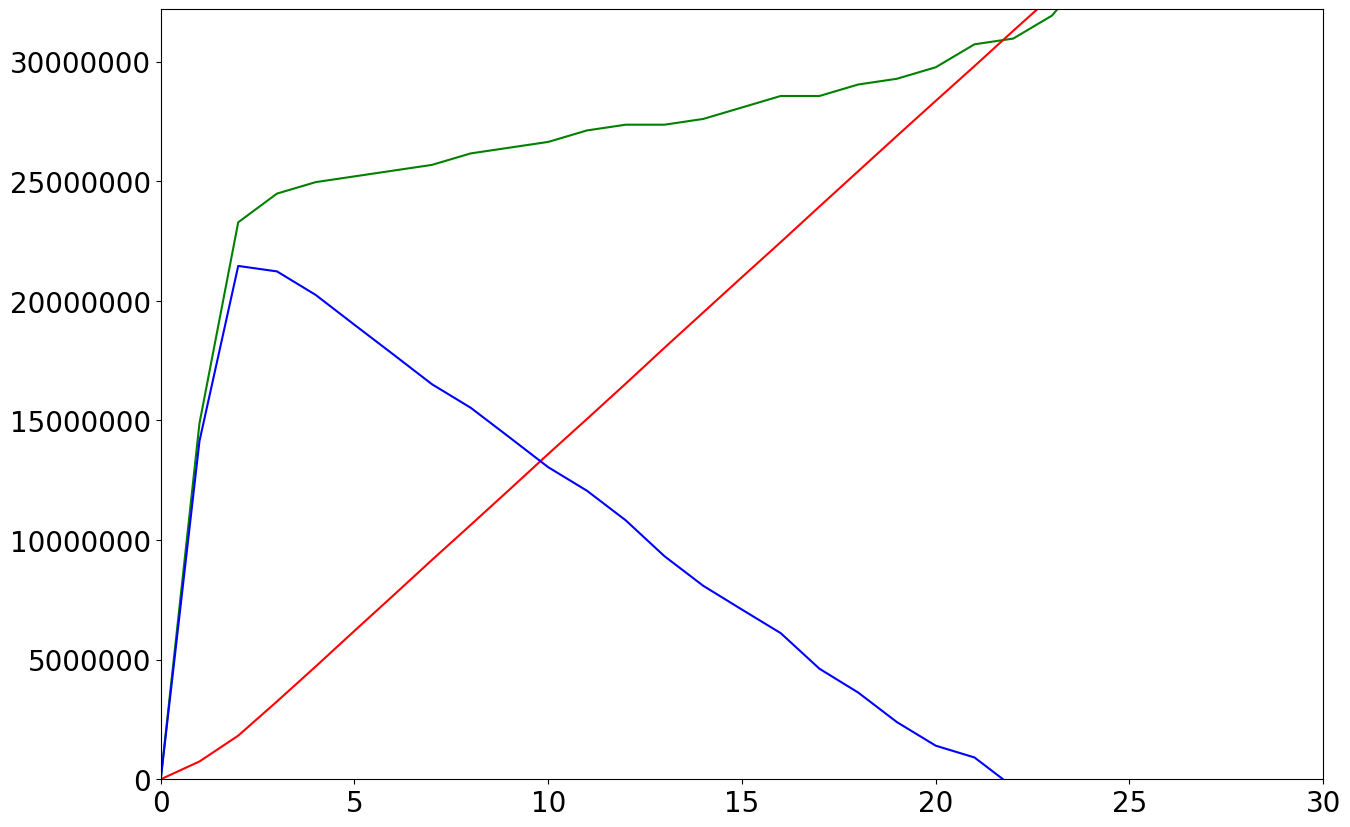

In [81]:
cost_fraud = 400
cost_fp = 20
# xmult: oot is only 2 out of 12 months, and 100,000 sample transactions out of 10 million/year
xoot = 12/2 * 10000000/100000
Financials_oot = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
for i in range(101):
    Financials_oot.loc[i, 'Fraud Savings'] = FDR_oot.loc[i, 'cb'] * cost_fraud * xoot
    Financials_oot.loc[i, 'FP Loss'] = FDR_oot.loc[i, 'cg'] * cost_fp * xoot
    Financials_oot.loc[i, 'Overall Savings'] = Financials_oot.loc[i, 'Fraud Savings'] - Financials_oot.loc[i, 'FP Loss']

max_savings = Financials_oot['Overall Savings'].max(0)
print('Max possible savings: '+'{:,}'.format(max_savings))
yupper = max_savings * 1.5
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(15,10))
plt.plot(Financials_oot['Fraud Savings'], color='green')
plt.plot(Financials_oot['FP Loss'], color='red')
plt.plot(Financials_oot['Overall Savings'], color='blue')
plt.xlim(0,30)
plt.ylim(0,yupper)
plt.ticklabel_format(style='plain')
plt.savefig('savings.png', format='png')


In [72]:
print("duration: ", datetime.now() - start_time)

duration:  0:20:29.782635
